In [38]:
from ruspy.data.data_reading import data_reading
from ruspy.data.data_processing import data_processing
from ruspy.estimation.estimation import estimate
from ruspy.estimation.estimation_cost_parameters import create_transition_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
beta = 0.9999
init_dict = {
    "groups": "group_4",
    "beta": beta,
    "maint_func": "linear",
    "binsize": 5000,
    "states": 90,
}

In [3]:
data_reading()
repl_data = data_processing(init_dict)
trans_results, cost_results = estimate(init_dict, repl_data, repl_4=True)
print(trans_results, cost_results)

{'state_count': array([[68, 94,  9, ...,  0,  0,  0],
       [ 0, 44, 59, ...,  0,  0,  0],
       [ 0,  0, 47, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  1,  1,  0],
       [ 0,  0,  0, ...,  0,  1,  1],
       [ 0,  0,  0, ...,  0,  0,  1]]), 'x': array([0.39189189, 0.59529357, 0.01281454]), 'fun': 3140.5705570938244, 'trans_count': array([1682, 2555,   55])}       fun: 163.58583993344618
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.16529009e-04, -3.69482223e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 12
   status: 0
  success: True
        x: array([10.07759093,  2.29408834])


In [4]:
max_state = trans_results["state_count"].shape[0] # 78
scale = 3 
num_bins = int(max_state / scale) # 26

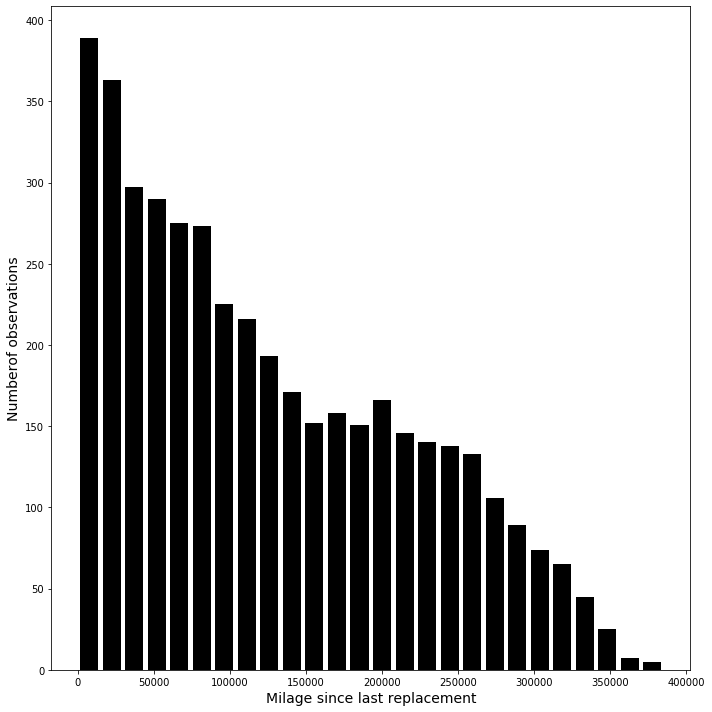

In [67]:
numobs_per_state = trans_results["state_count"].sum(axis=1)
hist_data = np.array([])
for i, val in enumerate(numobs_per_state):
    hist_data = np.append(hist_data, np.full(val, i))
hist_data = hist_data * init_dict["binsize"]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_ylabel(r"Numberof observations", fontsize=14)
ax.set_xlabel(r"Milage since last replacement", fontsize=14)
# ax.set_ylim([0, 1.15 * numobs_per_state[0]])
ax.hist(hist_data, bins=num_bins, color="black", rwidth=0.8)
plt.tight_layout()
plt.savefig("obs_per_miles.png")
plt.show()

ValueError: Colormap k is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

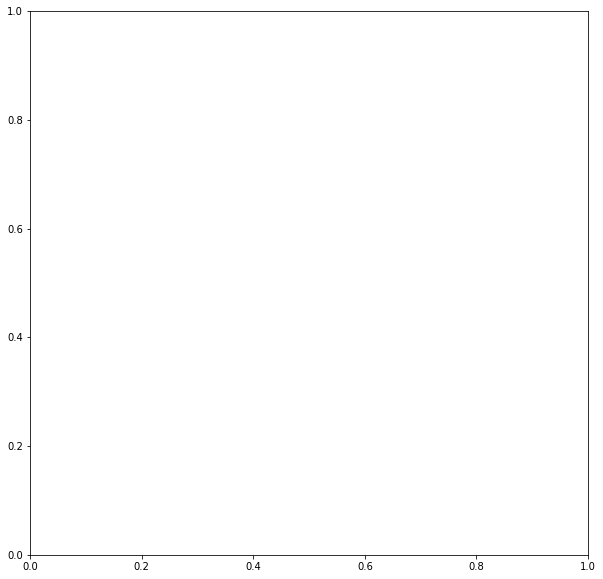

In [79]:
state_mat = trans_results["state_count"]
trans_mat = state_mat / state_mat.sum(axis=1)[:, None]
trans_mask = trans_mat == 0
start = 10
end = 30
index = range(start * 5, end * 5, 5)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    trans_mat[start:end, start:end],
    mask=trans_mask[start:end, start:end],
    ax=ax,
    cmap='k',
    xticklabels=index,
    yticklabels=index,
)
ax.set_ylabel(r"Current period mileage in thousands", fontsize=14)
ax.set_xlabel(r"Next period mileage in thousands", fontsize=14)
plt.xticks(rotation=1)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("trans_mat.png")
plt.show()